In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap

In [2]:
file_path = r"C:\Users\KIIT\001_ASU\DSE501\Term Project\Airline_Delay_Cause.csv"
df = pd.read_csv(file_path)

### Random Forest Regression

In [12]:
# Define features and target
features = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
            'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
            'arr_diverted', 'airport', 'carrier']
target = 'arr_del15'  # Target variable

# Select the relevant features and target
df_ml = df[features + [target]]

# Drop rows with missing values in the selected features and target
df_ml = df_ml.dropna()

# One-hot encode the 'airport' and 'carrier' categorical variables
X = pd.get_dummies(df_ml[features], columns=['airport', 'carrier'])

# Define the target
y = df_ml[target]

# Convert boolean columns to float
X = X.astype(float)
y = y.astype(float)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (10532, 388)
X_test shape: (4514, 388)
y_train shape: (10532,)
y_test shape: (4514,)


In [13]:
# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 224.94412326096585
R^2 Score: 0.9944903345747292


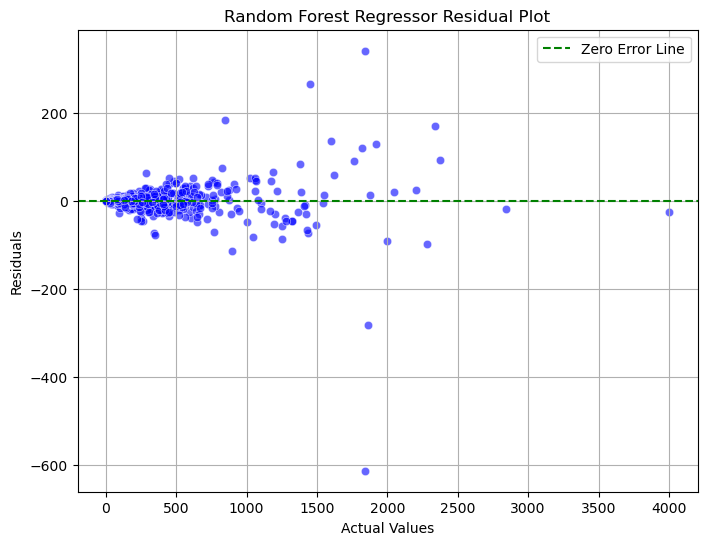

In [15]:
# Residual Calculation
residuals = y_test - y_pred

# Residual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='green', linestyle='--', label='Zero Error Line')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Random Forest Regressor Residual Plot')
plt.legend()
plt.grid(True)
plt.show()

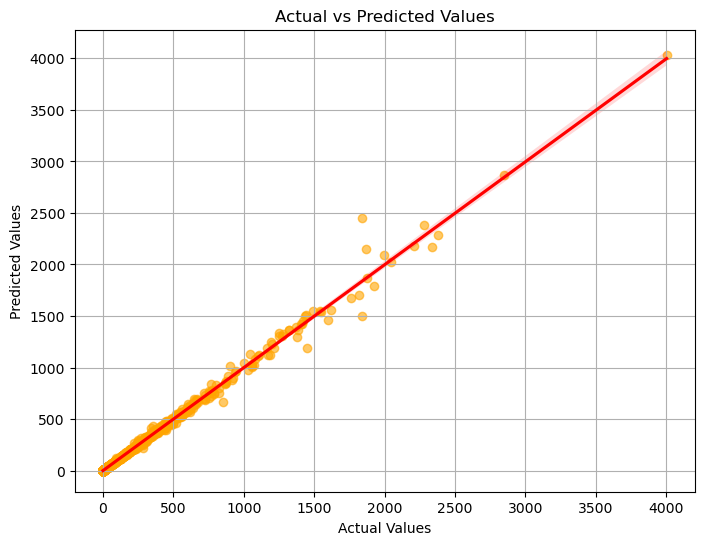

In [16]:
# Actual vs Predicted Plot
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.6, 'color': 'orange'}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()


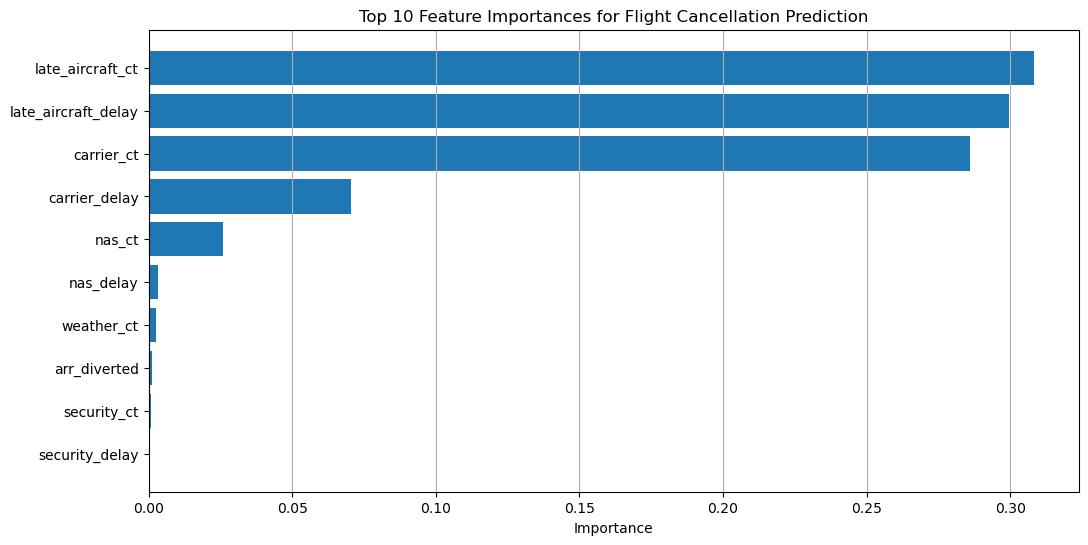

In [17]:
# Feature Importance Visualization
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances for Flight Cancellation Prediction')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

100%|===================| 4506/4514 [02:56<00:00]        

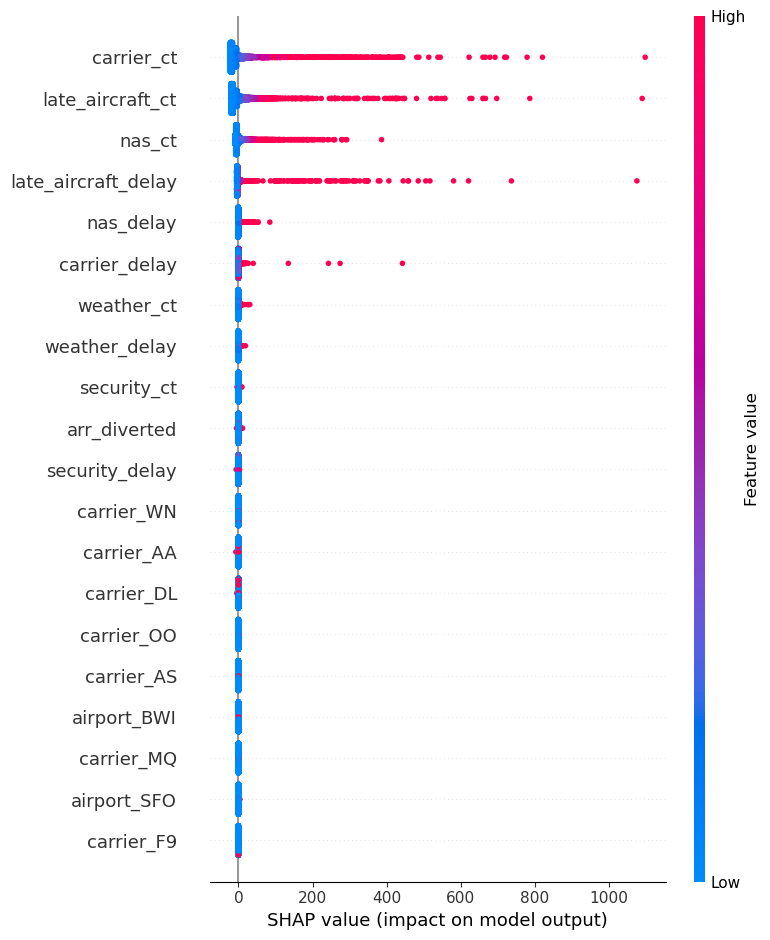

In [20]:
# Convert boolean columns to float
X_test = X_test.astype(float)

# Initialize SHAP Explainer for the Random Forest Regressor
explainer = shap.Explainer(model, X_test, check_additivity=False)

# Calculate SHAP values
shap_values = explainer(X_test, check_additivity=False)

# Summary Plot - Global Feature Importance
shap.summary_plot(shap_values, X_test)

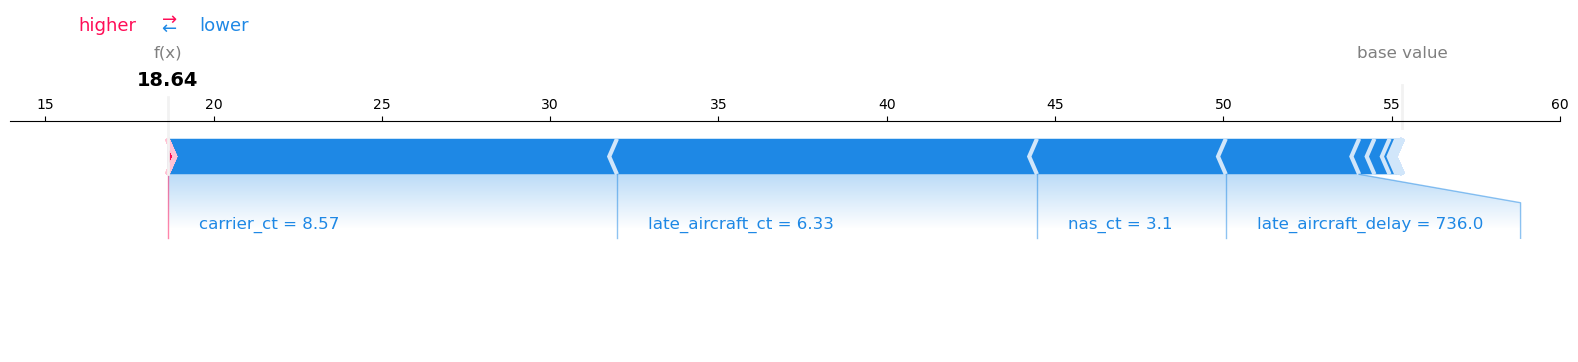

<Figure size 640x480 with 0 Axes>

In [25]:
# Save Force Plot as an Image
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True)
plt.savefig('shap_force_plot.png', bbox_inches='tight')

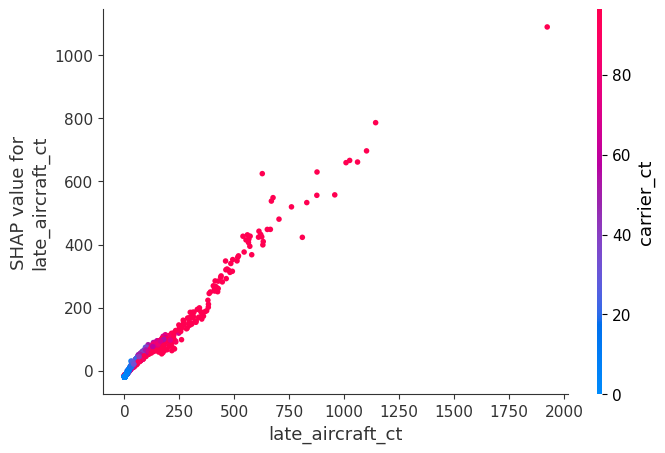

In [27]:
import shap

# Ensure the SHAP JavaScript library is initialized
shap.initjs()

# Generate the SHAP dependence plot
shap.dependence_plot("late_aircraft_ct", shap_values.values, X_test, feature_names=X_test.columns)

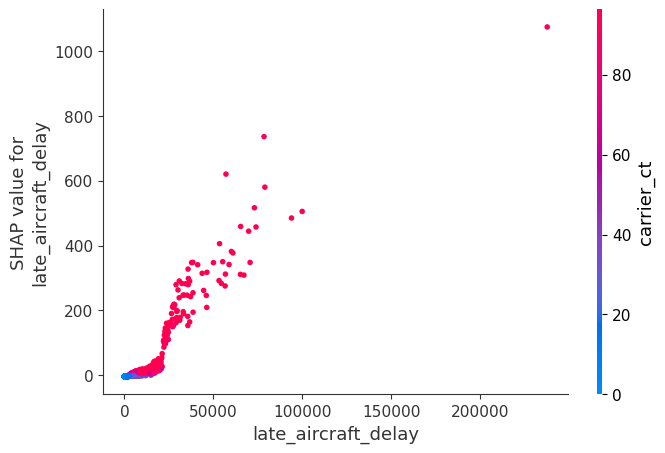

In [28]:
# Generate the SHAP dependence plot
shap.dependence_plot("late_aircraft_delay", shap_values.values, X_test, feature_names=X_test.columns)

Overall Insights and Actionable Steps
Target Late Aircraft Delays:
Frequency and duration of late aircraft delays are major drivers of flight delays. Prioritize strategies to:
Improve turnaround efficiency.
Optimize scheduling buffers to absorb minor delays.

Enhance Carrier Operations:
Since carrier_ct amplifies the impact of late aircraft delays, focus on improving carrier-specific processes, such as:
Maintenance protocols.
Crew scheduling and availability.

Monitor High-Impact Scenarios:
Use real-time monitoring to identify scenarios where both late aircraft delays and carrier delays are high, and implement preemptive actions to avoid cascading delays.

These insights can guide operational improvements and delay mitigation strategies for airlines and airports.

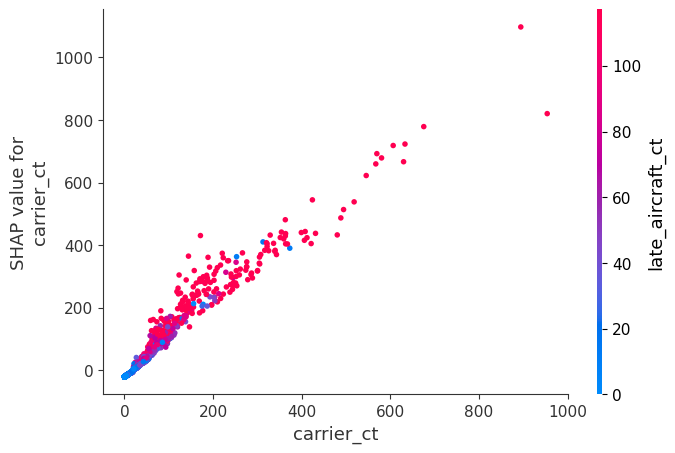

In [29]:
# Generate the SHAP dependence plot
shap.dependence_plot("carrier_ct", shap_values.values, X_test, feature_names=X_test.columns)

Dependence Plot for carrier_ct
X-axis: carrier_ct (count of carrier-related delays)
Y-axis: SHAP value for carrier_ct (impact on the prediction)
Color: late_aircraft_ct (count of late aircraft delays)

Key Observations:
Positive Correlation:
As the count of carrier-related delays (carrier_ct) increases, the SHAP values increase, indicating a strong positive impact on delays.
This suggests that more frequent carrier delays contribute significantly to higher delay predictions.

Interaction with late_aircraft_ct:
The color gradient shows that higher values of late_aircraft_ct (in red) amplify the impact of carrier_ct on delays.
When both carrier_ct and late_aircraft_ct are high, the predicted delays increase substantially.

Non-Linear Impact:
The impact of carrier_ct becomes more pronounced when it exceeds 200.
Delays increase steeply with higher carrier_ct, especially when late_aircraft_ct is also high.

Recommendations:
Reduce Carrier-Related Delays:
Focus on improving airline operations, such as:
Efficient maintenance procedures.
Crew scheduling and availability.

Mitigate Combined Delays:
Since carrier delays and late aircraft delays amplify each other, create contingency plans to manage situations where both delays are likely.

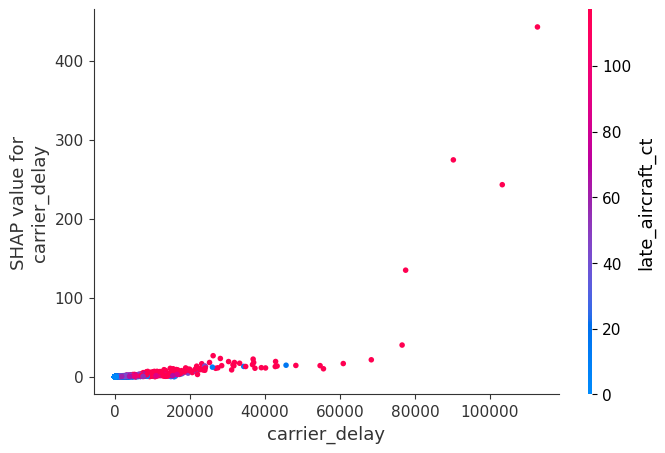

In [30]:
# Generate the SHAP dependence plot
shap.dependence_plot("carrier_delay", shap_values.values, X_test, feature_names=X_test.columns)

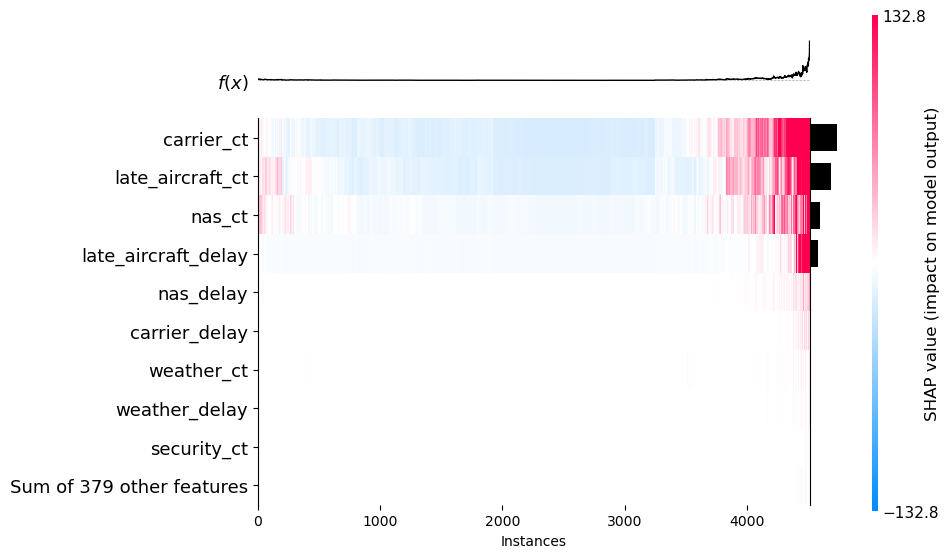

In [31]:
shap.plots.heatmap(shap_values)

### Random Forest Classifier

In [36]:
# Define the features
features = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
            'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
            'arr_diverted', 'airport', 'carrier']

# Define the target: 1 if delay > 60 minutes, 0 otherwise
df['target_above_60'] = (df['arr_del15'] > 60).astype(int)

In [37]:
# Drop rows with missing values in the selected features and target
df_ml = df[features + ['target_above_60']].dropna()

# One-hot encode the categorical variables 'airport' and 'carrier'
X = pd.get_dummies(df_ml[features], columns=['airport', 'carrier'])

# Define the target variable
y = df_ml['target_above_60']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9933569530558016

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3499
           1       0.99      0.98      0.99      1017

    accuracy                           0.99      4516
   macro avg       0.99      0.99      0.99      4516
weighted avg       0.99      0.99      0.99      4516



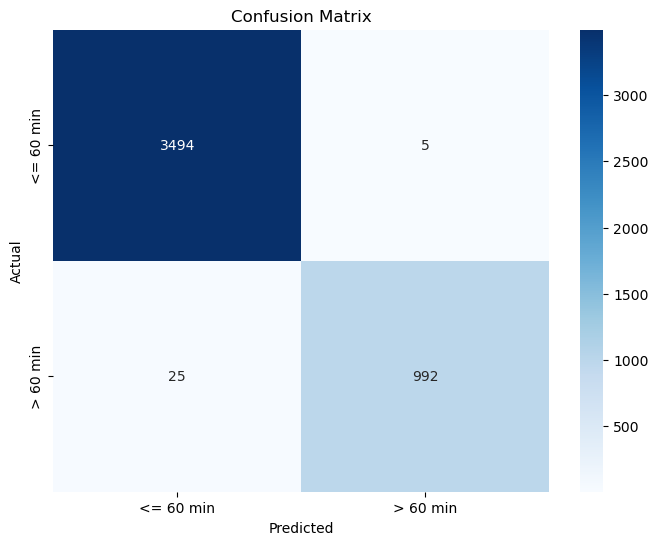

In [41]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<= 60 min', '> 60 min'], yticklabels=['<= 60 min', '> 60 min'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

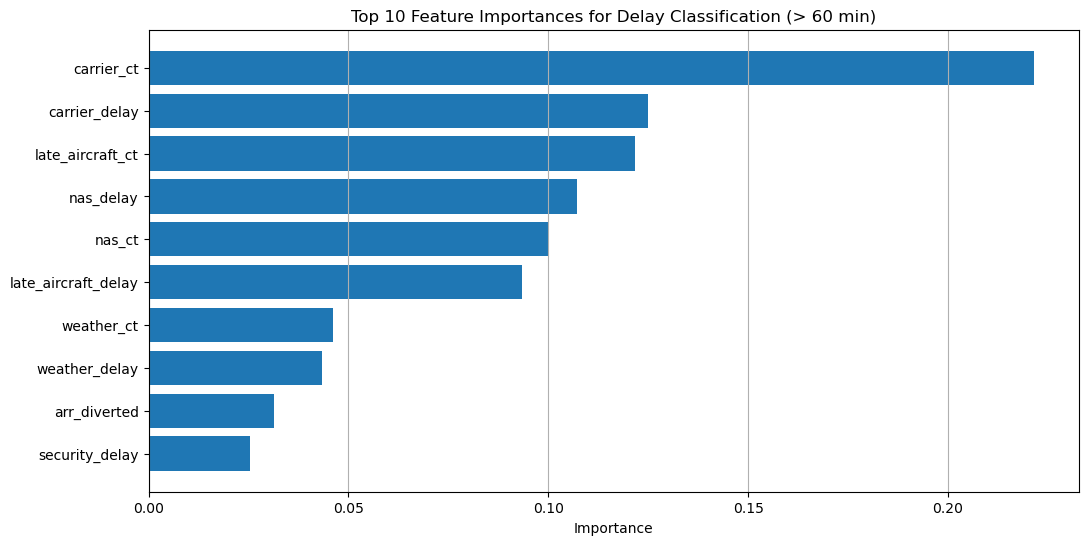

In [42]:
# Feature Importance Plot
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances for Delay Classification (> 60 min)')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()
